# ETR over the Past 25 Years Replication

Import data with 1 lagged year beforehand

In [1]:
import pandas as pd
import numpy as np
import wrds
db=wrds.Connection(wrds_username='krs84')

Loading library list...
Done


In [2]:
df=db.raw_sql('''select gvkey,datadate,fyear,txpd,pi,pifo,txfo,xrd,sale,at,ppent,capx,intan,dltt,dlc,xad,spi,tlcf,sich
                from comp.funda 
                where fyear >1987''')

Apply filter requirements:
1. Assets greater than 10 million
2. Txpd not null
3. Pretax income positive
4. Non-industrials
5. Require at least 5 observations per firm

In [3]:
df=df[df['at']>10].reset_index(drop=True)
df=df[df['txpd'].notna()].reset_index(drop=True)
df=df[df['pi']>0].reset_index(drop=True)
df=df[~((df['sich']>3999)&(df['sich']<5000))|((df['sich']>5999)&(df['sich']<7000))].reset_index(drop=True)
a=df.groupby('gvkey',as_index=False)['datadate'].count()
df=pd.merge(df,a[a['datadate']>=5]['gvkey'],on='gvkey')

Create a flag if the difference between the fiscal of one observation and the previous observation is greater than 1

In [4]:
df['flag']=df['fyear']-df.groupby('gvkey')['fyear'].shift(1)-1

Fill the variables with the appropriate amounts and lag appropriately

In [5]:
df['tlcf']=df['tlcf'].fillna(0)

In [6]:
df=df.sort_values(['gvkey','datadate'])
#Create lagged assets
df['lagat']=df.groupby('gvkey')['at'].shift(1)
#Ensure that we do not get null values for lagged assets. This shouldn't be a problem, but just in case.
df['lagat']=df['lagat'].replace(0,np.nan)
#lag tlcf
df['lagtlcf']=df.groupby('gvkey')['tlcf'].shift(1)
#Fill missing values with 0
df['spi']=df['spi'].fillna(0)
#Generate variables
df['special items']=df['spi']/(df['at'])
df['lagged special items']=df.groupby('gvkey')['special items'].shift(1)

In [7]:
#Generate an indicator variable for if lagtlcf is greater than 0
df['nol']=(df['lagtlcf']>0).astype(int)

Creates dnol which is (tlcf-lagged tlcf)/(lagged assets)

In [8]:
df['dnol']=(df['tlcf']-df['lagtlcf'])

In [9]:
df['dnol']=df['dnol']/df['lagat']

Drop observations whose are flagged. We do this because we require all observations to have all controls, and so any lagged variables should actually be missing if we do not have last years data. Hence, we drop them.

In [10]:
df=df[(df['flag']==0)|(df['flag'].isna())].reset_index(drop=True)

Indicator for if absolute value of pifo>0 or txfo is greater than 0

In [11]:
df['mne']=((np.abs(df['pifo'])>0)|(np.abs(df['txfo'])>0)).astype(int)

In [12]:
#Fill in xrd with 0 when missing
df['xrd']=df['xrd'].fillna(0)

In [13]:
df['r&d expense']=df['xrd']/df['sale']

In [14]:
df['log assets']=np.log(df['at'])

In [15]:
df['pp&e']=df['ppent']/df['at']

In [16]:
df['intangible assets']=df['intan']/df['at']

df['leverage']=(df['dltt']+df['dlc'])/df['at']

df['capital expenditures']=df['capx']/df['ppent']

df['xad']=df['xad'].fillna(0)

df['advertising expense']=df['xad']/df['sale']

df['cash etr']=df['txpd']/df['pi']

df['pifo']=df['pifo'].fillna(0)

The following bound the effective tax rate between 0 and 1, which ensures that it is an actual rate.

In [17]:
mask = df['cash etr'] > 1
column_name = 'cash etr'
df.loc[mask, column_name] = 1

In [18]:
mask = df['cash etr'] < 0
column_name = 'cash etr'
df.loc[mask, column_name] = 0

We want to drop any infinite values within our subset of control variables

In [19]:
df=df.replace([np.inf,-np.inf],np.nan)

In [20]:
df=df.dropna(subset=['cash etr','mne', 'log assets', 'r&d expense', 'pp&e',
       'intangible assets', 'leverage', 'capital expenditures',
       'advertising expense', 'special items','lagged special items','nol',
       'dnol', 'mne']).reset_index(drop=True)

In [21]:
df[['cash etr','mne', 'log assets', 'r&d expense', 'pp&e',
       'intangible assets', 'leverage', 'capital expenditures',
       'advertising expense', 'special items','lagged special items','nol',
       'dnol', 'mne']].describe()

,cash etr,mne,log assets,r&d expense,pp&e,intangible assets,leverage,capital expenditures,advertising expense,special items,lagged special items,nol,dnol,mne
count,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000,73083.000000
mean,0.284476,0.460340,6.652188,0.022621,0.244477,0.135056,0.215491,0.309847,0.010321,-0.002748,-0.001576,0.308936,0.005705,0.460340
std,0.219103,0.498428,2.122384,0.074910,0.234369,0.179895,0.213842,7.147521,0.028114,0.027663,0.105491,0.462058,0.997118,0.498428
min,0.000000,0.000000,2.302985,0.000000,0.000004,-0.005334,0.000000,-0.542576,0.000000,-0.347837,-0.597300,0.000000,-32.450772,0.000000
25%,0.131768,0.000000,5.113950,0.000000,0.053809,0.001898,0.043843,0.123554,0.000000,-0.003453,-0.002810,0.000000,0.000000,0.000000
50%,0.262863,0.000000,6.542220,0.000000,0.173170,0.049427,0.175201,0.202496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.375210,1.000000,7.986638,0.016352,0.360628,0.206923,0.325807,0.327947,0.009000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,14.914540,14.768279,0.999806,0.938866,6.915781,1713.000000,0.664981,2.594727,26.230976,1.000000,247.467438,1.000000


In [22]:
df[['cash etr','mne', 'log assets', 'r&d expense', 'pp&e',
       'intangible assets', 'leverage', 'capital expenditures',
       'advertising expense', 'special items','lagged special items','nol',
       'dnol', 'mne']].corr()

,cash etr,mne,log assets,r&d expense,pp&e,intangible assets,leverage,capital expenditures,advertising expense,special items,lagged special items,nol,dnol,mne
cash etr,1.000000,0.022892,-0.042799,-0.036168,-0.058480,0.012528,-0.013479,-0.007892,0.024487,-0.139431,-0.006926,-0.091784,0.000037,0.022892
mne,0.022892,1.000000,0.220071,0.178915,-0.082812,0.262852,0.032834,-0.004802,0.061580,-0.061753,-0.016699,0.263886,-0.001811,1.000000
log assets,-0.042799,0.220071,1.000000,-0.035738,-0.025894,0.152442,0.188576,-0.009861,0.013681,-0.030234,-0.013685,0.120139,0.006728,0.220071
r&d expense,-0.036168,0.178915,-0.035738,1.000000,-0.125287,0.056146,-0.130475,0.001486,0.026039,-0.028525,0.015485,0.108071,-0.000209,0.178915
pp&e,-0.058480,-0.082812,-0.025894,-0.125287,1.000000,-0.238054,0.218559,-0.014769,-0.070244,0.010541,0.005942,-0.029517,-0.003496,-0.082812
intangible assets,0.012528,0.262852,0.152442,0.056146,-0.238054,1.000000,0.170218,-0.004037,0.070786,-0.069453,-0.017826,0.231251,0.013629,0.262852
leverage,-0.013479,0.032834,0.188576,-0.130475,0.218559,0.170218,1.000000,-0.008740,0.000395,-0.029451,0.019659,0.064464,0.005409,0.032834
capital expenditures,-0.007892,-0.004802,-0.009861,0.001486,-0.014769,-0.004037,-0.008740,1.000000,-0.001276,0.001069,0.000126,0.000954,-0.000030,-0.004802
advertising expense,0.024487,0.061580,0.013681,0.026039,-0.070244,0.070786,0.000395,-0.001276,1.000000,-0.023652,-0.007230,0.010865,-0.000434,0.061580
special items,-0.139431,-0.061753,-0.030234,-0.028525,0.010541,-0.069453,-0.029451,0.001069,-0.023652,1.000000,0.021104,-0.024559,-0.002776,-0.061753


Here I graph the number of multinationals by year

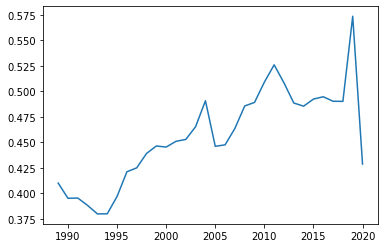

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df['datadate']=pd.to_datetime(df['datadate'])
df['year']=df['datadate'].dt.year
a=df.groupby('year')['mne'].mean()
plt.plot(a)

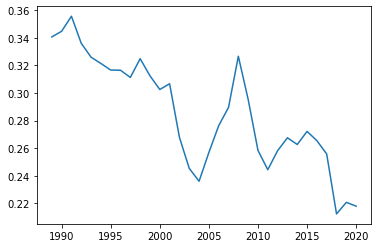

In [30]:
a=df.groupby('year')['cash etr'].mean()
plt.plot(a)

Next is the cash effective tax rate by year

Generate time variable

In [31]:
df['time']=df['fyear']-df['fyear'].min()

In [32]:
df['cash_etr']=df['cash etr']

Run the cash etr regressions against time for the overall group, and then for multinationals and domestic firms exclusively

In [38]:
import ipystata
df2=df[['cash_etr','time','mne']]

In [39]:
%%stata -d df2
reg cash_etr time, robust
preserve
keep if mne==1
reg cash_etr time, robust
restore
preserve
keep if mne==0
reg cash_etr time, robust
restore



Linear regression                               Number of obs     =     73,083
                                                F(1, 73081)       =    1324.90
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0174
                                                Root MSE          =     .21719

------------------------------------------------------------------------------
             |               Robust
    cash_etr |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        time |  -.0034369   .0000944   -36.40   0.000    -.0036219   -.0032518
       _cons |   .3387079   .0017457   194.03   0.000     .3352864    .3421294
------------------------------------------------------------------------------
(39,440 observations deleted)

Linear regression                               Number of obs 